In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
print(os.listdir("/content/drive/My Drive/CSVNEW"))

['WM_hourly.csv', 'VC_hourly.csv', 'tubelights_hourly.csv', 'TOAST_hourly.csv', 'REF_hourly.csv', 'fans_hourly.csv', 'Geyser_hourly (1).csv', 'oven_hourly.csv', 'refregirator_hourly.csv', 'vaccum_cleaner_hourly.csv']


In [ ]:
fpath='/content/drive/My Drive/CSVNEW/fans_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,Fans
0,2020:01:01 00:00:00,296.0
1,2020:01:01 01:00:00,296.0
2,2020:01:01 02:00:00,296.0
3,2020:01:01 03:00:00,222.0
4,2020:01:01 04:00:00,148.0


In [ ]:
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,Fans
Datetime,
2020:01:01 00:00:00,296.0
2020:01:01 01:00:00,296.0
2020:01:01 02:00:00,296.0
2020:01:01 03:00:00,222.0
2020:01:01 04:00:00,148.0


In [ ]:
df.isna().sum()

Fans    0
dtype: int64

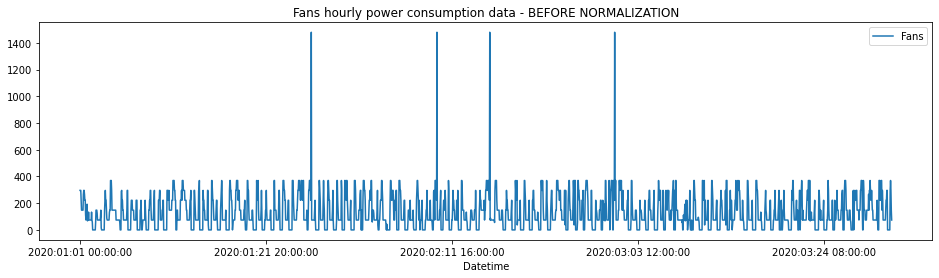

In [ ]:
df.plot(figsize=(16,4),legend=True)
plt.title('Fans hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [ ]:
  def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['Fans']=scaler.fit_transform(df['Fans'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape


(2184, 1)

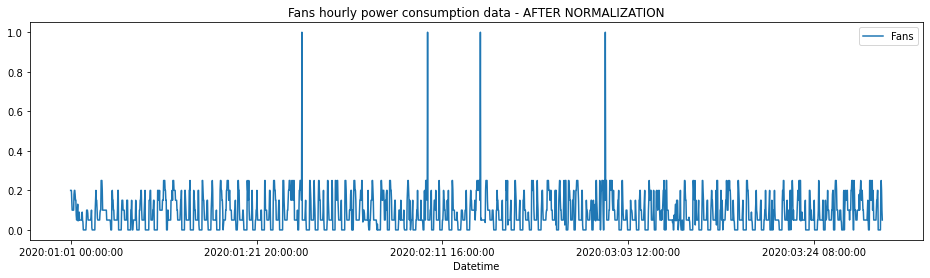

In [ ]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('Fans hourly power consumption data - AFTER NORMALIZATION')
plt.show()

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 2000 days are going to be used in test
    X_test = X_train[2000:]             
    y_test = y_train[2000:]
    
    #2 first 2000 days are going to be used in training
    X_train = X_train[:2000]           
    y_train = y_train[:2000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (2000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [ ]:
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (2000, 20, 1)
y_train.shape =  (2000,)
X_test.shape =  (164, 20, 1)
y_test.shape =  (164,)


In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=20, batch_size=50)

Epoch 1/20
40/40 [==============================] - 0s 12ms/step - loss: 0.1268
Epoch 2/20
40/40 [==============================] - 1s 14ms/step - loss: 0.0441
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.0261
Epoch 4/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0184
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0145
Epoch 6/20
40/40 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 7/20
40/40 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 8/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0093
Epoch 9/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0085
Epoch 10/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0082
Epoch 11/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0083
Epoch 12/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 13/20
40/40 [==================

In [ ]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.3169176607097469


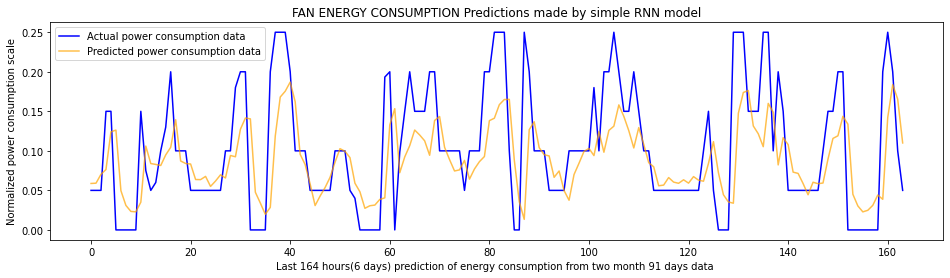

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Last 164 hours(6 days) prediction of energy consumption from two month 91 days data ')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "FAN ENERGY CONSUMPTION Predictions made by simple RNN model")

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=20, batch_size=50)

Epoch 1/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0081
Epoch 2/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0078
Epoch 3/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0077
Epoch 4/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0076
Epoch 5/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0076
Epoch 6/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0073
Epoch 7/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0068
Epoch 8/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0063
Epoch 9/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0058
Epoch 10/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0057
Epoch 11/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 12/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 13/20
40/40 [==================

In [ ]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.3626863931434735


In [ ]:
plot_predictions(y_test, lstm_predictions, "FAN ENERGY CONSUMPTION Predictions made by LSTM model")

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.xlabel('Last 164 hours(6 days) prediction of energy consumption from two month 91 days data ')
plt.ylabel('Normalized power consumption scale')
plt.show()

